# Importing Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy
from math import pi,acos
import os
import seaborn as sns
from scipy.constants import epsilon_0 as epsilon
%matplotlib inline

In [2]:
#Run this to reset the results
results= pd.DataFrame(columns = ['LC Name', 'Temperature', 'Applied Voltage','Rise Time','Decay Time','Total Response Time','Visco-Elastic Ratio'])

In [3]:
#Loading the data
path="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch2" #Enter Loaction WHere CSV data is kept


name_of_LC="Pure 5CB"# Change this to show type of LC
thickness= 7.01E-6 #in Metres
area=77E-6 #in Metres^2
empty_c=99.6E-12 #in Farad
wavelength=633E-9 #in metre
#Dielectric Anisotropy depends on temperature

dielectric_anisotropy=[None,None,None,None]
temps=['26','28','30','32']
voltages=['4','5','6','7','8','9','10']
#epsilon_a=[1,1,1,1]

if not os.path.exists(path + "/Analysis") :
    os.mkdir (path + "/Analysis")
output_path=path+"/Analysis"

# Finding the Threshold Voltage

In [4]:
#Reading the datafile containing the Threshold Voltage data
vthdata=pd.read_csv(path+"/Vth.csv",skiprows=0)
#Normalizing Voltage
vthdata['Intensity']=(vthdata['Intensity']-vthdata['Intensity'].min())/(vthdata['Intensity'].max()-vthdata['Intensity'].min())
temp=32

vthdata.describe()

,Voltage,Intensity
count,105.000000,105.000000
mean,4.130476,0.601167
std,2.944487,0.325692
min,0.100000,0.000000
25%,1.820000,0.285221
50%,3.300000,0.696377
75%,5.900000,0.917194
max,12.000000,1.000000


Threshold Votage:1.66V
Combined Elastic Constant:9.357006709608352e-12


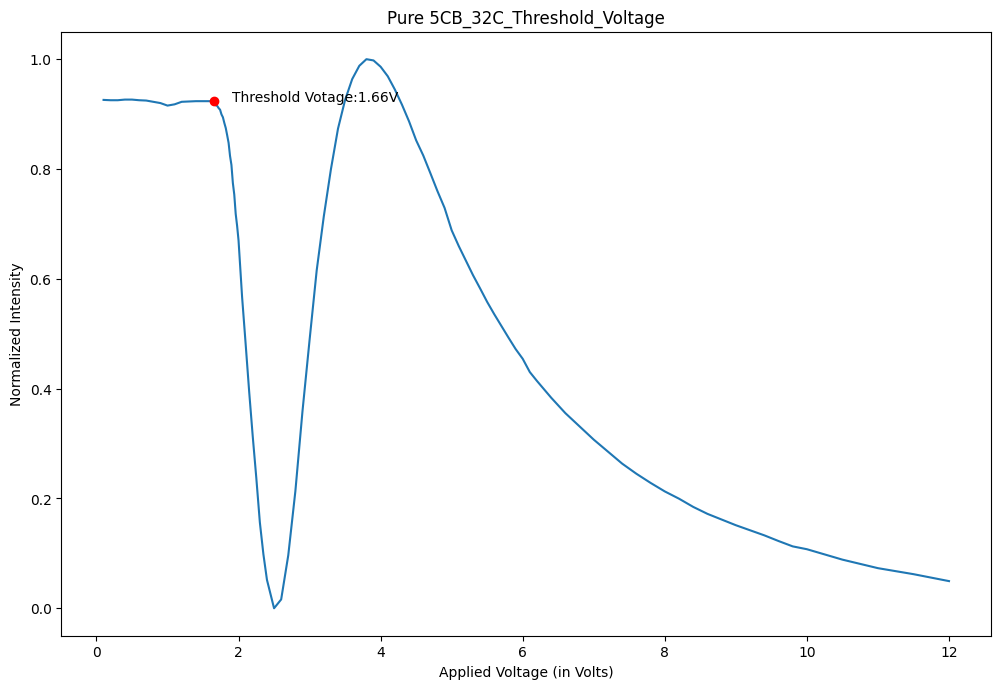

In [19]:
#Plotting the normalized intensity vs voltage data
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.ylabel("Normalized Intensity")
plt.xlabel("Applied Voltage (in Volts)")
plt.plot(vthdata['Voltage'],vthdata['Intensity'])
#indx_max = np.argmax(vthdata['Intensity'])
indx_max=18
plt.plot(vthdata['Voltage'][indx_max], vthdata['Intensity'][indx_max], 'ro')
vth=vthdata['Voltage'][indx_max]
K=(vth*2/pi)*scipy.constants.epsilon_0
#plt.plot(vth*np.ones(2),[1,vthdata['Intensity'][indx_max]])
plt.annotate("Threshold Votage:"+ str(vth)+'V',(vthdata['Voltage'][indx_max], vthdata['Intensity'][indx_max]),xytext=(vthdata['Voltage'][indx_max]+0.25, vthdata['Intensity'][indx_max]))
print("Threshold Votage:"+ str(vth)+'V')
print("Combined Elastic Constant:"+ str(K))
plt.title(name_of_LC+"_32C_"+"Threshold_Voltage")
plt.savefig(output_path+"/"+name_of_LC+"_"+"Threshold_Voltage.jpg", dpi=300,bbox_inches='tight')
plt.show()

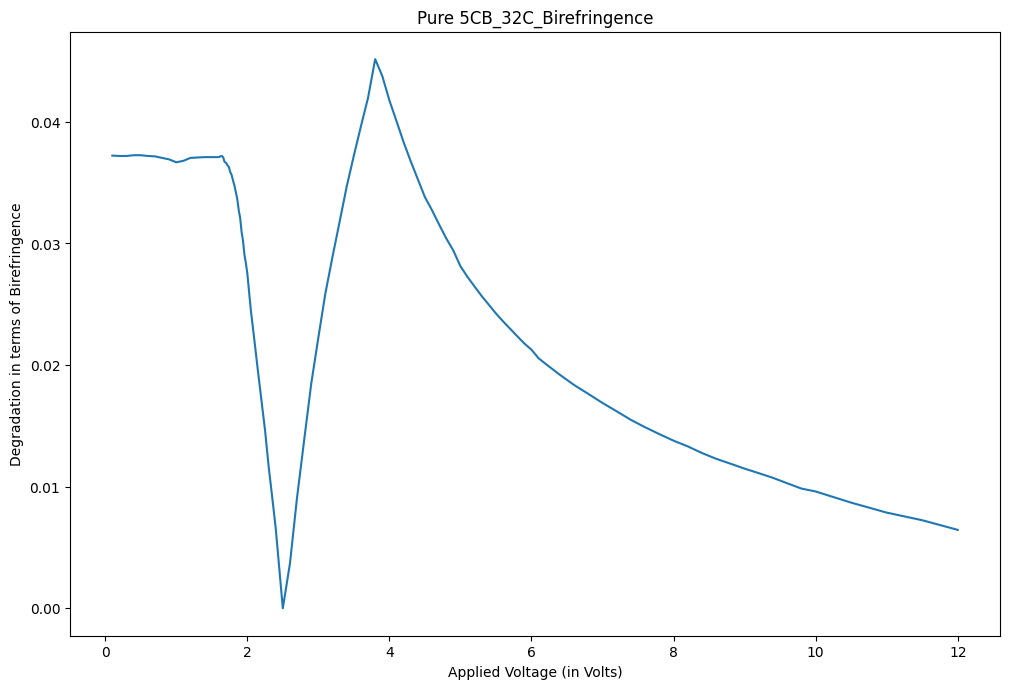

In [12]:
#FInding the birefringence from the Intensity vs Voltage Data
#Threshold Voltage depends on temperature of material
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.ylabel("Degradation in terms of Birefringence")
plt.xlabel("Applied Voltage (in Volts)")
biref=np.arccos(1-vthdata['Intensity']*2)/2/pi/thickness*wavelength
plt.plot(vthdata['Voltage'],biref)

indx_max = np.argmax(biref)
#plt.plot(vthdata['Voltage'][indx_max], biref[indx_max], 'ro')
b=biref[indx_max]
#plt.plot(vth*np.ones(2),[1,vthdata['Intensity'][indx_max]])
#plt.annotate("Max Birefringence:"+ str(b),(vthdata['Voltage'][indx_max], biref[indx_max]),xytext=(vthdata['Voltage'][indx_max]+0.25, biref[indx_max]))
#print("Max Birefrigence:"+ str(b)+'V')

plt.title(name_of_LC+"_32C_"+"Birefringence")
plt.savefig(output_path+"/"+name_of_LC+"_"+"Birefringence.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
vths=[None,None,None,vth]

# Analysis of Each Temperature and Voltage Case

In [ ]:
if not os.path.exists(output_path+"/TransmittancevsTime") :
    os.mkdir (output_path+"/TransmittancevsTime")
for temp in temps:
    for voltage in voltages:
        try :
            #temp=str(temp)
            #voltage=str(voltage)
            input_path=path+"/"+temp+"_"+voltage+"_2.csv"
            df=pd.read_csv(input_path,skiprows=1)
            #Normalizing the Volt to represent transmittance
            df.Volt=(df.Volt-df.Volt.min())/(df.Volt.max()-df.Volt.min())
        except :
          print ("Incorrect CSV directory or filename")
          continue
        else:
            print("File Exists. Start Analysis")
        plt.figure(figsize=(12, 8), dpi=100, linewidth=0.1)
        plt.xlabel("Time (in seconds)")
        plt.ylabel("Transmittance")

        #Have set the window size as a constant = 33. If the number of intersections on
        #the 0.9 line or 0.1 line are more than 6, then icncrease window size
        window_size =33
        smooth=savgol_filter(df.Volt,window_size,2) #Creating a smoothened Curve us SavGol filter with window size 25 

        plt.plot(df.second,smooth) #Printing the smooth curve
        plt.plot(df.second,df.Volt)#Printing the actual curve

        plt.plot(df.second,0.9*np.ones(df.second.shape)) #Printing horizontal line at 0.9
        plt.plot(df.second,0.1*np.ones(df.second.shape)) #Printing horizontal line at 0.1

        #Finding position where the curve closses the 0.9 transmittance
        idx = np.argwhere(np.diff(np.sign(smooth - 0.9))).flatten()
        if(len(idx)!=6):
            print("Error in top. Number of points greater than 6. Increase window size and retry")
            exit(1)
        idx=idx[1:5] #Eliminating First and last points
        plt.plot(df.second[idx], 0.9*np.ones(idx.size), 'ro') #Plotting Points of intersection
        #print(len(idx))
        idx_top=idx
        for i in range(len(idx)):
            plt.annotate("T90="+str(round(df.second[idx[i]],4)),(df.second[idx[i]], 0.9),xytext =(df.second[idx[i]]+0.0005-max(0,0.006*pow(-1,i+1)), 0.91))


        #Finding position where the curve closses the 0.1 transmittance
        idx = np.argwhere(np.diff(np.sign(smooth - 0.1))).flatten()
        if(len(idx)!=6):
            print("Error in bot. Number of points greater than 6. Increase window size and retry")
            exit(1)
        idx=idx[1:5] #Eliminating First and last points
        plt.plot(df.second[idx], 0.1*np.ones(idx.size), 'bo') #Plotting Points of intersection
        #print(len(idx))
        idx_bot=idx
        for i in range(len(idx)):
            plt.annotate("T10="+str(round(df.second[idx[i]],4)),(df.second[idx[i]], 0.1),xytext =(df.second[idx[i]]+0.0005-max(0,0.006*pow(-1,i)), 0.11-max(0,0.05*pow(-1,i))))

        #Calculating RiseTime and DecayTime (average of 2 sets)
        rise_time=((df.second[idx_bot[0]]-df.second[idx_top[0]])+(df.second[idx_bot[2]]-df.second[idx_top[2]]))/2
        decay_time=((df.second[idx_top[1]]-df.second[idx_bot[1]])+(df.second[idx_top[3]]-df.second[idx_bot[3]]))/2
        response_time=rise_time+decay_time
        #Printing the times
        #print("Rise Time = ",rise_time,"seconds")
        #print("Decay Time = ",decay_time,"seconds")
        #print("Response Time = ",response_time,"seconds")
        plt.annotate("Rise Time = "+str(round(rise_time,4)),xy=(0.019,1))
        plt.annotate("Decay Time="+str(round(decay_time,4)),xy=(0.019,0.97))
        plt.annotate("Resp. Time="+str(round(response_time,4)),xy=(0.019,0.94))
        plt.annotate(name_of_LC,xy=(-0.027,1))
        plt.annotate("Appl. Volt. = "+voltage+"V",xy=(-0.027,0.97))
        plt.annotate("Temp = "+temp+"C",xy=(-0.027,0.94))
        plt.title(name_of_LC+"_"+temp+"C_"+voltage+"V")
        plt.savefig(output_path+"/TransmittancevsTime/"+temp+"_"+voltage+".jpg", dpi=300,bbox_inches='tight')
        #plt.show()
        results=results.append({'LC Name':name_of_LC, 'Temperature':temp, 'Applied Voltage':voltage,'Rise Time':rise_time,'Decay Time':decay_time,'Total Response Time': response_time,'Visco-Elastic Ratio':decay_time*(pi/thickness)**2},ignore_index=True)
            

In [ ]:
#If you are happy with the results, you can write it to a csv file.
results.to_csv(output_path+"/"+"RespTimevsAppVolt.csv", index=False)

In [13]:
results=pd.read_csv(output_path+"/RespTimevsAppVolt.csv")
results.tail()

,LC Name,Temperature,Applied Voltage,Rise Time,Decay Time,Total Response Time,Visco-Elastic Ratio
51,Pure 5CB,32,6,0.001125,0.006400,0.007525,1.285416e+09
52,Pure 5CB,32,7,0.000838,0.006275,0.007112,1.260310e+09
53,Pure 5CB,32,8,0.000700,0.006525,0.007225,1.310522e+09
54,Pure 5CB,32,9,0.000588,0.006537,0.007125,1.313032e+09
55,Pure 5CB,32,10,0.000550,0.006400,0.006950,1.285416e+09


In [ ]:
#Plotting the response time vs Applied Voltage
if not os.path.exists(output_path+"/ResponseTimevsTemp") :
    os.mkdir (output_path+"/ResponseTimevsTemp")
for idx,temp in enumerate(temps):
    plt.figure(1,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Time (in seconds)")
    plt.xlabel("Applied Voltage (in Volts)")
    plt.plot(results['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],results['Total Response Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.plot(results['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],results['Rise Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.plot(results['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],results['Decay Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.legend(['Total Response Time','Rise Time','Decay Time'])
    plt.title(name_of_LC+" - "+temp+" Celcius")
    plt.savefig(output_path+"/ResponseTimevsTemp/"+name_of_LC+"_"+temp+".jpg", dpi=300,bbox_inches='tight')
    plt.show()


In [ ]:
#Plotting the response time vs Applied Voltage
if not os.path.exists(output_path+"/ResponseTimevsVoltage") :
    os.mkdir (output_path+"/ResponseTimevsVoltage")
results1=results.sort_values(['Applied Voltage','Temperature'])
print(results1.head(20))
for idx,voltage in enumerate(voltages):
    plt.figure(1,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Time (in seconds)")
    plt.xlabel("Temperature (in Celcius)")
    plt.plot(results1['Temperature'][idx*len(temps):(idx+1)*len(temps)],results1['Total Response Time'][idx*len(temps):(idx+1)*len(temps)],'-o')
    plt.plot(results1['Temperature'][idx*len(temps):(idx+1)*len(temps)],results1['Rise Time'][idx*len(temps):(idx+1)*len(temps)],'-o')
    plt.plot(results1['Temperature'][idx*len(temps):(idx+1)*len(temps)],results1['Decay Time'][idx*len(temps):(idx+1)*len(temps)],'-o')
    plt.legend(['Total Response Time','Rise Time','Decay Time'])
    plt.title(name_of_LC+" - "+voltage+"V")
    plt.savefig(output_path+"/ResponseTimevsVoltage/"+name_of_LC+"_"+voltage+"V.jpg", dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
titles=['Rise Time','Decay Time','Total Response Time']
if not os.path.exists(output_path+"/ResponseTimeMap") :
    os.mkdir (output_path+"/ResponseTimeMap")
for title in titles:
    plt.figure(1,figsize=(12, 8), dpi=100, linewidth=0.1)
    teste = np.resize(results[title].to_numpy(copy=True),(len(temps),len(voltages)))
    tas=pd.DataFrame(teste,temps,voltages)
    sns.heatmap(tas, annot=True,cmap='coolwarm')
    plt.xlabel("Applied Voltage (in Volts)")
    plt.ylabel("Temperature (in Celcius)")
    plt.title(name_of_LC+" - "+title+" (in seconds)")
    plt.savefig(output_path+"/ResponseTimeMap/"+name_of_LC+"_"+title+".jpg", dpi=300,bbox_inches='tight')
    plt.show()


# Analysing properties of the Liquid Crystal

In [14]:
#Setting up dataframe for recording derived properties 
properties=pd.DataFrame(columns = ['Property', 'Value', 'Units'])

In [15]:
#If the above Property is fine, append the property to list of properties
properties=properties.append({'Property':prop, 'Value':value, 'Units':units},ignore_index=True)
properties.tail()

NameError: name 'prop' is not defined

In [ ]:
# If all the properties are fine, write out the properties to a csv file
properties.to_csv(output_path+"/"+"Derived_Properties.csv", index=False)

In [16]:
#Calculating K from Threshold Voltage
#K depends on temperature
k_by_dielectric_anisotropy=(vth*2/pi)**2*epsilon
print("Combined elastic constant K divided by dielectric anisotropy "+"at temp "+str(temp)+" celcius = "+str(k_by_dielectric_anisotropy))

Combined elastic constant K divided by dielectric anisotropy at temp 32 celcius = 9.888380099311249e-12


In [ ]:
#Calulating Rotational Viscocity by Dielectric Anisotrpy from Rise Time
gamma_by_DA=[]
for i in range(21,28):
    gamma_by_DA.append(results['Rise Time'][i]*epsilon*((results['Applied Voltage'][i])**2-vth**2)/thickness**2)
    print(results['Applied Voltage'][i],gamma_by_DA[i-21])

In [ ]:
#Comparing Visco Elasitc Ratios
for i in range(21,28):
    print(results['Visco-Elastic Ratio'][i],gamma_by_DA[i-21]/k_by_dielectric_anisotropy,results['Visco-Elastic Ratio'][i]-gamma_by_DA[i-21]/k_by_dielectric_anisotropy)